<a href="https://colab.research.google.com/github/taitip-supha/DeepLearn-Keras/blob/main/02_CNN/CNN02_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare the Environment

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-9fa1a9cf-db79-2612-aa3f-dcb9a378eccc)


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
NumPy 1.21.5
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


# Ex 1 : Data Augmentation with ImageDataGenerator

## Load MNIST dataset

In [ ]:
#Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}\n")
print( f"y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train):.4f} ,max(y_train)={np.max(y_train):.4f}")
print( f"y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test):.4f} ,max(y_test)={np.max(y_test):.4f}")

x_train.shape=(60000, 28, 28), x_train.dtype=uint8, min(x_train)=0.0000 ,max(x_train)=255.0000
x_test.shape=(10000, 28, 28), x_test.dtype=uint8, min(x_test)=0.0000 ,max(x_test)=255.0000

y_train.shape=(60000,), y_train.dtype=uint8, min(y_train)=0.0000 ,max(y_train)=9.0000
y_test.shape=(10000,), y_test.dtype=uint8, min(y_test)=0.0000 ,max(y_test)=9.0000


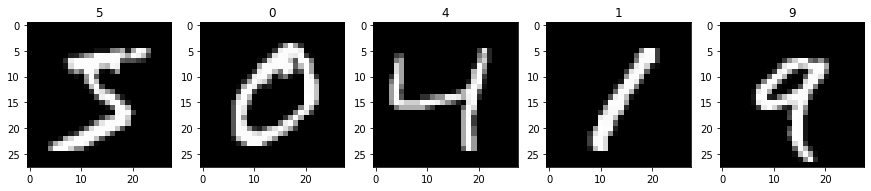

In [ ]:
#Visualize the first five image in x_train
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(150+1+i).set_title(y_train[i])
  plt.imshow(x_train[i] ,cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Convert data uint8 to float32 for tensorflow
x_train = x_train.astype(np.float32)
x_test  = x_test.astype(np.float32)
print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}")

x_train.shape=(60000, 28, 28), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=255.0000
x_test.shape=(10000, 28, 28), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=255.0000


In [ ]:
# Scaling value from 0-255 to 0 - 1
x_train /= 255
x_test /= 255
print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}")

x_train.shape=(60000, 28, 28), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=1.0000
x_test.shape=(10000, 28, 28), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=1.0000


In [ ]:
# Conv2D input shape
x_train = np.reshape(x_train, (-1,28,28,1))
x_test  = np.reshape(x_test, (-1,28,28,1))

print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}")

x_train.shape=(60000, 28, 28, 1), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=1.0000
x_test.shape=(10000, 28, 28, 1), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=1.0000


## Create the Network architecture

In [ ]:
model = tf.keras.models.Sequential()

#input layer
model.add(tf.keras.layers.InputLayer((28, 28, 1), name='Input'))

#Hidden Layer : Feature Extractor
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same' ,activation='relu' ,name='conv01'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same' ,activation='relu' ,name='conv02'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same' ,activation='relu' ,name='conv03'))

#Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu', name='dense01'))

#Output Layer
model.add(tf.keras.layers.Dense(10, activation='softmax', name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv01 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv02 (Conv2D)             (None, 28, 28, 64)        18496     
                                                                 
 conv03 (Conv2D)             (None, 28, 28, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense01 (Dense)             (None, 32)                802848    
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 840,458
Trainable params: 840,458
Non-trai

## Data augmentation

In [ ]:
#Create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)
train_datagen.fit(x_train)

===== Train batch no. 1/3 =====


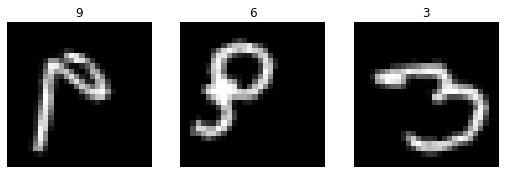

===== Train batch no. 2/3 =====


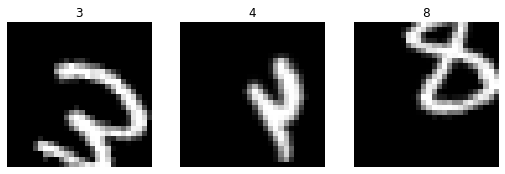

===== Train batch no. 3/3 =====


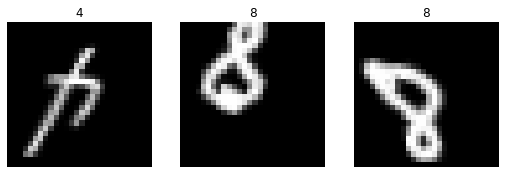

In [ ]:
from IPython.core.pylabtools import figsize
# Visualize some Training Image from the ImageDataGenerator
n_show = 3
for b, (x_batch, y_batch) in enumerate( train_datagen.flow(x_train, y_train, batch_size=n_show ,subset='training')):
  print(f"{'='*5} Train batch no. {b+1}/{n_show} {'='*5}")
  plt.figure(figsize=(15,5))
  for i in range(n_show):
    plt.subplot(150+1+i).set_title(y_batch[i])
    plt.imshow(x_batch[i].reshape(28,28), cmap='gray')
    plt.axis('off') #Remove all tick marks
  plt.show()
  if b+1 >= n_show:
    break

## Compile and train the model

In [ ]:
#Compile with default values for both optimizer and loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

***Becareful***, validation_data=train_datagen.flow(x_train, y_train, subset='validation') is the validation data will be augmen if data augmentation in validation st is not preferred, we may use validation_data=[x_test, y_test] here just for simplificat!!

In [ ]:
#Fit the model on each batch of training data * with real-time data augmentation
history = model.fit( train_datagen.flow( x_train, y_train, batch_size=128, subset='training'),
                    epochs=20,
                    verbose=1,
                    validation_data=train_datagen.flow(x_train, y_train, subset='validation')
                    )

Epoch 1/20
375/375 [==============================] - 23s 38ms/step - loss: 1.3026 - acc: 0.5402 - val_loss: 0.9128 - val_acc: 0.6824
Epoch 2/20
375/375 [==============================] - 14s 36ms/step - loss: 0.7948 - acc: 0.7258 - val_loss: 0.6822 - val_acc: 0.7692
Epoch 3/20
375/375 [==============================] - 13s 36ms/step - loss: 0.6056 - acc: 0.7992 - val_loss: 0.5426 - val_acc: 0.8227
Epoch 4/20
375/375 [==============================] - 13s 36ms/step - loss: 0.4857 - acc: 0.8419 - val_loss: 0.4536 - val_acc: 0.8495
Epoch 5/20
375/375 [==============================] - 14s 36ms/step - loss: 0.4207 - acc: 0.8630 - val_loss: 0.3916 - val_acc: 0.8763
Epoch 6/20
375/375 [==============================] - 13s 36ms/step - loss: 0.3826 - acc: 0.8741 - val_loss: 0.4075 - val_acc: 0.8660
Epoch 7/20
375/375 [==============================] - 14s 36ms/step - loss: 0.3546 - acc: 0.8846 - val_loss: 0.3348 - val_acc: 0.8927
Epoch 8/20
375/375 [==============================] - 14s 36ms

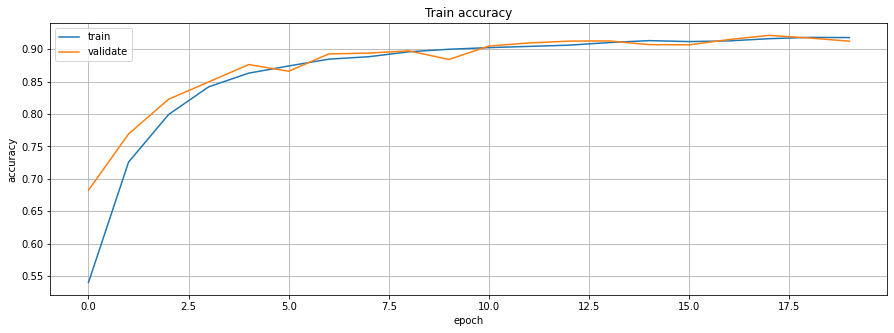

In [ ]:
#Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()
plt.show()

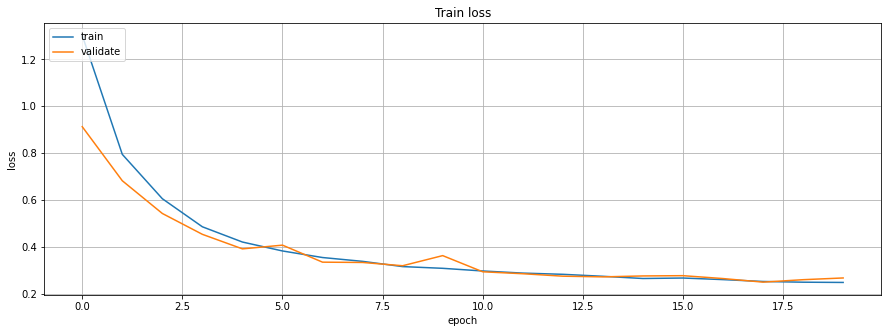

In [ ]:
#Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()
plt.show()

## Evaluate the model on test set

In [ ]:
results = model.evaluate(x_test, y_test ,batch_size = 128)
print(f"{model.metrics_names} = {results}")

79/79 [==============================] - 0s 4ms/step - loss: 0.1963 - acc: 0.9358
['loss', 'acc'] = [0.19629724323749542, 0.9358000159263611]


## Inference

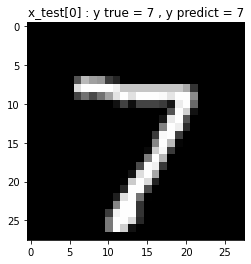

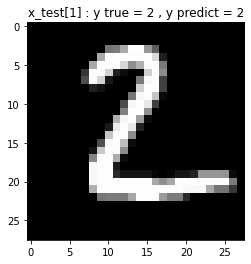

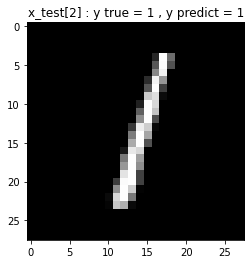

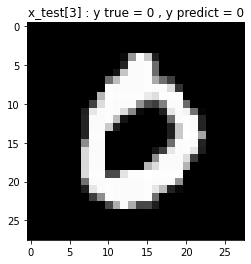

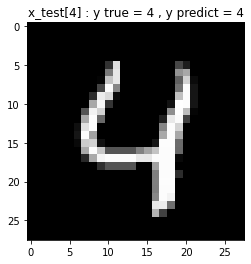

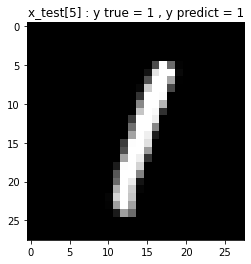

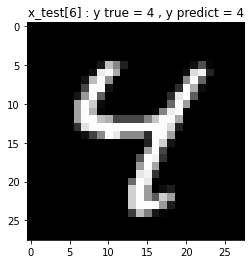

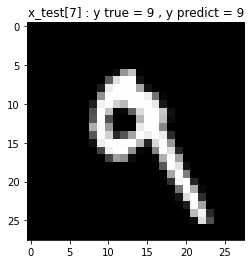

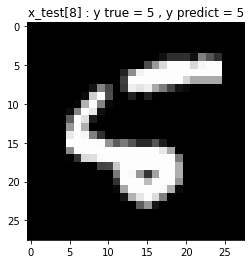

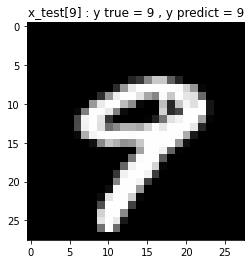

In [ ]:
#test ussing the model on the first 10 image in x_test
for i in range(10):
  y_pred = model.predict(x_test[i].reshape(1,28,28,1))

  plt.imshow( x_test[i].reshape(28,28), cmap='gray')
  plt.title(f"x_test[{i}] : y true = {y_test[i]} , y predict = {np.argmax(y_pred)}")
  plt.show()


# Ex 2. Create the net work architecture with data augmentation layers

## Prepare the MNIST dataset

In [ ]:
#Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}\n")
print( f"y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train):.4f} ,max(y_train)={np.max(y_train):.4f}")
print( f"y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test):.4f} ,max(y_test)={np.max(y_test):.4f}")

11501568/11490434 [==============================] - 0s 0us/step
x_train.shape=(60000, 28, 28), x_train.dtype=uint8, min(x_train)=0.0000 ,max(x_train)=255.0000
x_test.shape=(10000, 28, 28), x_test.dtype=uint8, min(x_test)=0.0000 ,max(x_test)=255.0000

y_train.shape=(60000,), y_train.dtype=uint8, min(y_train)=0.0000 ,max(y_train)=9.0000
y_test.shape=(10000,), y_test.dtype=uint8, min(y_test)=0.0000 ,max(y_test)=9.0000


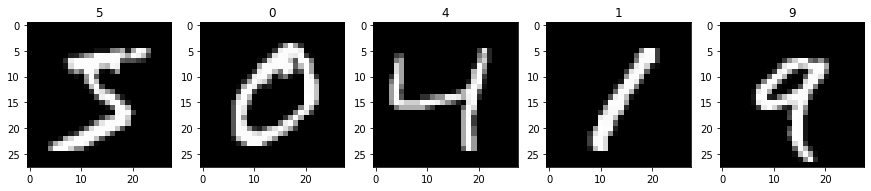

In [ ]:
#Visualize the first five image in x_train
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(150+1+i).set_title(y_train[i])
  plt.imshow(x_train[i] ,cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Convert data uint8 to float32 for tensorflow
x_train = x_train.astype(np.float32)
x_test  = x_test.astype(np.float32)
print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}")

x_train.shape=(60000, 28, 28), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=255.0000
x_test.shape=(10000, 28, 28), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=255.0000


In [ ]:
# Scaling value from 0-255 to 0 - 1
x_train /= 255
x_test /= 255
print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}")

x_train.shape=(60000, 28, 28), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=1.0000
x_test.shape=(10000, 28, 28), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=1.0000


In [ ]:
# Conv2D input shape
x_train = np.reshape(x_train, (-1,28,28,1))
x_test  = np.reshape(x_test, (-1,28,28,1))

print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}")

x_train.shape=(60000, 28, 28, 1), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=1.0000
x_test.shape=(10000, 28, 28, 1), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=1.0000


## Create the network architecture

### Test data augmentation layers
Data augmentation layer is inactive at test time so input images will only be augmented during calls to model.fit() ( not use when model.evaluate or model.predict())

In [ ]:
m_dataqug = tf.keras.models.Sequential(name='dataaug')

# Data augmentation layer
m_dataqug.add(tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', name='rand_flip'))
m_dataqug.add(tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', name='rand_trans'))
m_dataqug.add(tf.keras.layers.RandomRotation(factor=0.2, fill_mode='constant', name='rand_rot'))



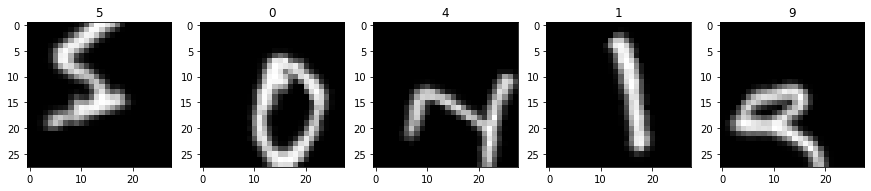

In [ ]:
#test using augmentation model
plt.figure(figsize=(15,5))
for i in range(5):
  x_aug = m_dataqug(tf.convert_to_tensor(x_train[i]))

  plt.subplot(150+1+i).set_title(y_train[i])
  plt.imshow(x_aug.numpy().reshape(28,28) ,cmap=plt.get_cmap('gray'))
plt.show()

### Create main network

In [ ]:
model = tf.keras.models.Sequential()

#Input layer
model.add(tf.keras.layers.InputLayer((28,28,1), name='Input'))

#data augmentation layer
model.add(tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', name='rand_flip'))
model.add(tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', name='rand_trans'))
model.add(tf.keras.layers.RandomRotation(factor=0.2, fill_mode='constant', name='rand_rot'))

# Feature Extractor Layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', name='conv01'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', name='conv02'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', name='conv03'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool'))

#Classifier Layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu', name='dense'))

#output layer
model.add(tf.keras.layers.Dense(10, activation='softmax', name='output'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rand_flip (RandomFlip)      (None, 28, 28, 1)         0         
                                                                 
 rand_trans (RandomTranslati  (None, 28, 28, 1)        0         
 on)                                                             
                                                                 
 rand_rot (RandomRotation)   (None, 28, 28, 1)         0         
                                                                 
 conv01 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv02 (Conv2D)             (None, 28, 28, 64)        18496     
                                                                 
 conv03 (Conv2D)             (None, 28, 28, 32)        18464     
                                                      

## Compile and Train model

In [ ]:
model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2 )

Epoch 1/20
375/375 [==============================] - 15s 11ms/step - loss: 1.7391 - acc: 0.3675 - val_loss: 1.2626 - val_acc: 0.5496
Epoch 2/20
375/375 [==============================] - 4s 10ms/step - loss: 1.2512 - acc: 0.5605 - val_loss: 1.0301 - val_acc: 0.6450
Epoch 3/20
375/375 [==============================] - 4s 10ms/step - loss: 1.0181 - acc: 0.6455 - val_loss: 0.7725 - val_acc: 0.7487
Epoch 4/20
375/375 [==============================] - 4s 10ms/step - loss: 0.8797 - acc: 0.7029 - val_loss: 0.6917 - val_acc: 0.7776
Epoch 5/20
375/375 [==============================] - 5s 12ms/step - loss: 0.7973 - acc: 0.7315 - val_loss: 0.5795 - val_acc: 0.8204
Epoch 6/20
375/375 [==============================] - 4s 10ms/step - loss: 0.7373 - acc: 0.7536 - val_loss: 0.5530 - val_acc: 0.8277
Epoch 7/20
375/375 [==============================] - 4s 11ms/step - loss: 0.6836 - acc: 0.7731 - val_loss: 0.5742 - val_acc: 0.8217
Epoch 8/20
375/375 [==============================] - 4s 11ms/step -

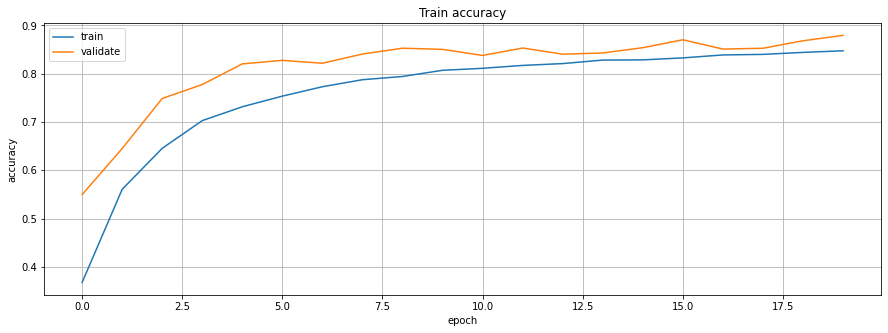

In [ ]:
#Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()
plt.show()

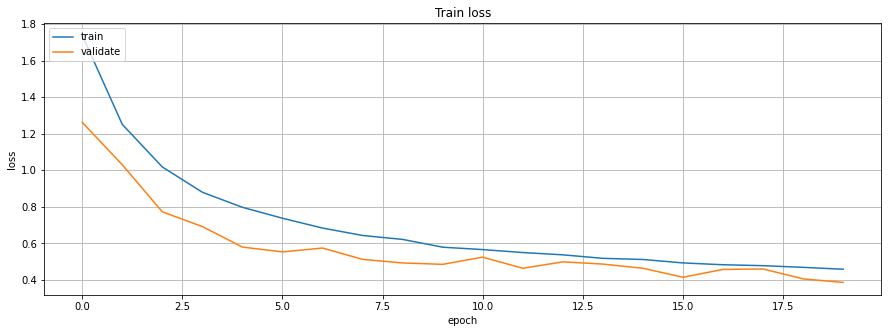

In [ ]:
#Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()
plt.show()

## Evaluate the model on test set

In [ ]:
results = model.evaluate(x_test, y_test ,batch_size = 128)
print(f"{model.metrics_names} = {results}")

79/79 [==============================] - 0s 5ms/step - loss: 0.3830 - acc: 0.8783
['loss', 'acc'] = [0.3829983174800873, 0.8783000111579895]


## Inference

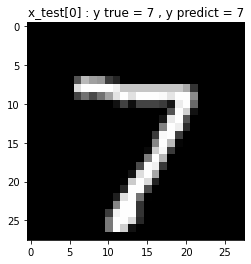

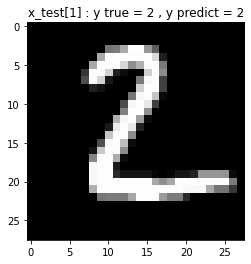

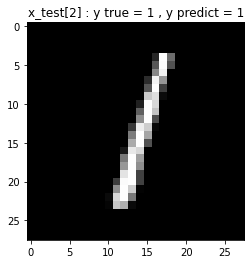

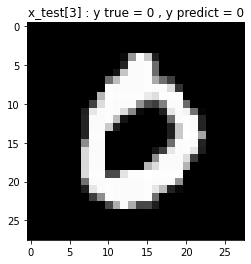

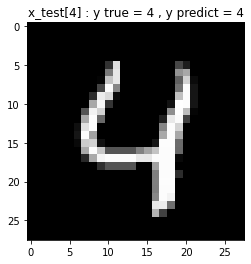

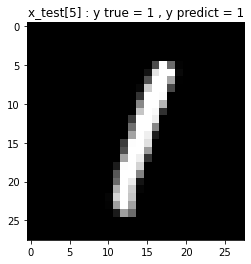

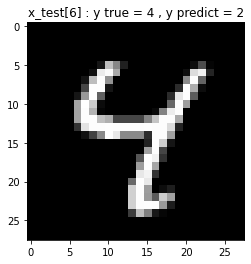

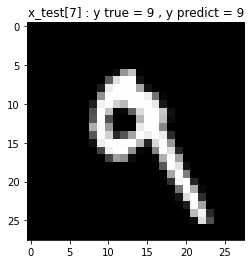

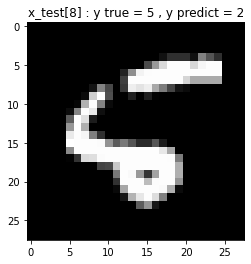

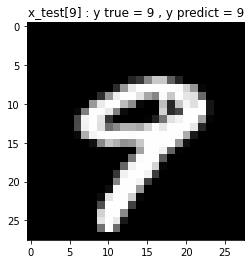

In [ ]:
#test ussing the model on the first 10 image in x_test
for i in range(10):
  y_pred = model.predict(x_test[i].reshape(1,28,28,1))

  plt.imshow( x_test[i].reshape(28,28), cmap='gray')
  plt.title(f"x_test[{i}] : y true = {y_test[i]} , y predict = {np.argmax(y_pred)}")
  plt.show()


# Ex 3 : Load Pretrained Model from Keras

## 1) Load pretrained model
In this example, load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part.
</br>By default, VGG-16 is designed for an input image of dimension 224x224x3

In [ ]:
vgg16 = tf.keras.applications.VGG16(weights = 'imagenet' ,include_top=True)
vgg16.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## 2) Use the pretrained Model

### load Image

In [ ]:
## load a test image from internet
!wget -O image "https://kb.rspca.org.au/wp-content/uploads/2018/11/cat-predation.jpg"

--2022-02-05 10:13:01--  https://kb.rspca.org.au/wp-content/uploads/2018/11/cat-predation.jpg
Resolving kb.rspca.org.au (kb.rspca.org.au)... 150.107.72.173
Connecting to kb.rspca.org.au (kb.rspca.org.au)|150.107.72.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172331 (168K) [image/jpeg]
Saving to: ‘image’

image               100%[===================>] 168.29K   400KB/s    in 0.4s    

2022-02-05 10:13:03 (400 KB/s) - ‘image’ saved [172331/172331]



In [ ]:
#Load an image form disk as PIL.Image.Imge
img = tf.keras.preprocessing.image.load_img("./image"  ,target_size=(224,224))
print(f" type(img) = {type(img)}")

 type(img) = <class 'PIL.Image.Image'>


In [ ]:
#Covert PIL Image to Numpy ndarray
x = tf.keras.preprocessing.image.img_to_array(img)
print( f" type(x)={type(x)}, x.shape={x.shape}, x.dtype={x.dtype}, min(x)={np.min(x):0.4f}, max(x)={np.max(x):0.4f}")

 type(x)=<class 'numpy.ndarray'>, x.shape=(224, 224, 3), x.dtype=float32, min(x)=0.0000, max(x)=255.0000


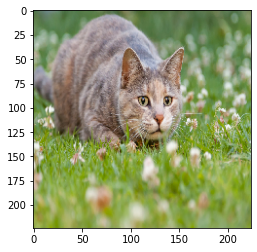

In [ ]:
#display image
plt.imshow(x.astype(np.uint8))
plt.show()

### Use the model to predict class

In [ ]:
#Preprocess the image following requrement of VGG-16
x_vgg16 = tf.keras.applications.vgg16.preprocess_input(x)
print( f" type(x_vgg16)={type(x_vgg16)}, x_vgg16.shape={x_vgg16.shape}, x_vgg16.dtype={x_vgg16.dtype}, min(x_vgg16)={np.min(x_vgg16):0.4f}, max(x_vgg16)={np.max(x_vgg16):0.4f}")

 type(x_vgg16)=<class 'numpy.ndarray'>, x_vgg16.shape=(224, 224, 3), x_vgg16.dtype=float32, min(x_vgg16)=-117.6800, max(x_vgg16)=151.0610


In [ ]:
#Predict this image
pred = vgg16.predict(np.expand_dims(x_vgg16, axis=0))

In [ ]:
# Decode the top 10 Classes
pred_class = tf.keras.applications.vgg16.decode_predictions(pred ,top=10)[0]
for i,prediction in enumerate(pred_class):
  print(f"Rank {i+1} : {prediction}")

Rank 1 : ('n02123159', 'tiger_cat', 0.84794176)
Rank 2 : ('n02123045', 'tabby', 0.090564236)
Rank 3 : ('n02124075', 'Egyptian_cat', 0.052910406)
Rank 4 : ('n02127052', 'lynx', 0.0066464436)
Rank 5 : ('n02325366', 'wood_rabbit', 0.00019709406)
Rank 6 : ('n02909870', 'bucket', 8.7352426e-05)
Rank 7 : ('n03223299', 'doormat', 8.090838e-05)
Rank 8 : ('n03942813', 'ping-pong_ball', 7.7770026e-05)
Rank 9 : ('n04409515', 'tennis_ball', 7.6117816e-05)
Rank 10 : ('n02487347', 'macaque', 6.401601e-05)


#Ex 4 : Transfer Learning

## Prepare training data

In [ ]:
# Load CIFAR-10 Color image dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#Inspect the dataset
print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}\n")
print( f"y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train):.4f} ,max(y_train)={np.max(y_train):.4f}")
print( f"y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test):.4f} ,max(y_test)={np.max(y_test):.4f}")

170508288/170498071 [==============================] - 6s 0us/step
x_train.shape=(50000, 32, 32, 3), x_train.dtype=uint8, min(x_train)=0.0000 ,max(x_train)=255.0000
x_test.shape=(10000, 32, 32, 3), x_test.dtype=uint8, min(x_test)=0.0000 ,max(x_test)=255.0000

y_train.shape=(50000, 1), y_train.dtype=uint8, min(y_train)=0.0000 ,max(y_train)=9.0000
y_test.shape=(10000, 1), y_test.dtype=uint8, min(y_test)=0.0000 ,max(y_test)=9.0000


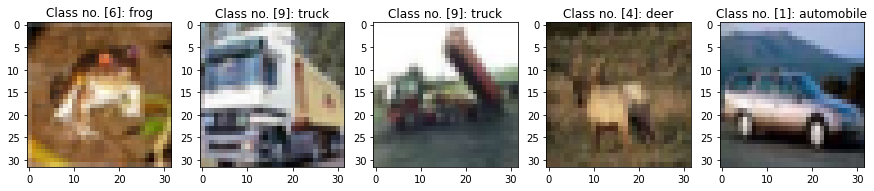

In [ ]:
#Visulize the first image in x_train
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(150+1+i).set_title(f"Class no. {y_train[i]}: {cifar10_labels[int(y_train[i])]}")
  plt.imshow( x_train[i])
plt.show()

In [ ]:
# Preprocess CIFAR-10 dataset to match VGG-16's requirement
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

print( f"x_train_vgg.shape={x_train_vgg.shape}, x_train_vgg.dtype={x_train_vgg.dtype}, min(x_train_vgg)={np.min(x_train_vgg):.4f} ,max(x_train_vgg)={np.max(x_train_vgg):.4f}")
print( f"x_test_vgg.shape={x_test_vgg.shape}, x_test_vgg.dtype={x_test_vgg.dtype}, min(x_test_vgg)={np.min(x_test_vgg):.4f} ,max(x_test_vgg)={np.max(x_test_vgg):.4f}\n")

x_train_vgg.shape=(50000, 32, 32, 3), x_train_vgg.dtype=float32, min(x_train_vgg)=-123.6800 ,max(x_train_vgg)=151.0610
x_test_vgg.shape=(10000, 32, 32, 3), x_test_vgg.dtype=float32, min(x_test_vgg)=-123.6800 ,max(x_test_vgg)=151.0610



## Load the pre trained model (Only Feature extractor) and Change input shape

In [ ]:
# Load the ImageNet VGG-16 model. Default of input_shape is 224x224x3 
_,img_w,img_h,img_dim = x_train.shape
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_w,img_h,img_dim))
vgg_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

## Prepare Model for transfer learning and fine turn

### Access and Freeze layer(s) in model with Keras API

In [ ]:
# Access a layer by index
a = vgg_extractor.layers[0]
print(f"Layer {a}: name = {a.name}, trainable = {a.trainable}")

Layer <keras.engine.input_layer.InputLayer object at 0x7f2322170d50>: name = input_3, trainable = True


In [ ]:
# Access a layer by name
b = vgg_extractor.get_layer('block5_conv1')
print(f"Layer {b}: name = {b.name}, trainable = {b.trainable}")

Layer <keras.layers.convolutional.Conv2D object at 0x7f2325c4ecd0>: name = block5_conv1, trainable = True


In [ ]:
#Iterate over all layers in the model
for i,j_layer in enumerate(vgg_extractor.layers):
  print(f"Layer {i} {j_layer}: name = {j_layer.name}, trainable = {j_layer.trainable}")

Layer 0 <keras.engine.input_layer.InputLayer object at 0x7f2322170d50>: name = input_3, trainable = True
Layer 1 <keras.layers.convolutional.Conv2D object at 0x7f23221701d0>: name = block1_conv1, trainable = True
Layer 2 <keras.layers.convolutional.Conv2D object at 0x7f2421fb7250>: name = block1_conv2, trainable = True
Layer 3 <keras.layers.pooling.MaxPooling2D object at 0x7f2325bbcc10>: name = block1_pool, trainable = True
Layer 4 <keras.layers.convolutional.Conv2D object at 0x7f2325dc2350>: name = block2_conv1, trainable = True
Layer 5 <keras.layers.convolutional.Conv2D object at 0x7f2325cd3bd0>: name = block2_conv2, trainable = True
Layer 6 <keras.layers.pooling.MaxPooling2D object at 0x7f23221edc10>: name = block2_pool, trainable = True
Layer 7 <keras.layers.convolutional.Conv2D object at 0x7f2325cd3410>: name = block3_conv1, trainable = True
Layer 8 <keras.layers.convolutional.Conv2D object at 0x7f23221a6f10>: name = block3_conv2, trainable = True
Layer 9 <keras.layers.convolution

In [ ]:
#Freeze all layers in the model
vgg_extractor.trainable = False
for i,j_layer in enumerate(vgg_extractor.layers):
  print(f"Layer {i} {j_layer}: name = {j_layer.name}, trainable = {j_layer.trainable}")

Layer 0 <keras.engine.input_layer.InputLayer object at 0x7f2322170d50>: name = input_3, trainable = False
Layer 1 <keras.layers.convolutional.Conv2D object at 0x7f23221701d0>: name = block1_conv1, trainable = False
Layer 2 <keras.layers.convolutional.Conv2D object at 0x7f2421fb7250>: name = block1_conv2, trainable = False
Layer 3 <keras.layers.pooling.MaxPooling2D object at 0x7f2325bbcc10>: name = block1_pool, trainable = False
Layer 4 <keras.layers.convolutional.Conv2D object at 0x7f2325dc2350>: name = block2_conv1, trainable = False
Layer 5 <keras.layers.convolutional.Conv2D object at 0x7f2325cd3bd0>: name = block2_conv2, trainable = False
Layer 6 <keras.layers.pooling.MaxPooling2D object at 0x7f23221edc10>: name = block2_pool, trainable = False
Layer 7 <keras.layers.convolutional.Conv2D object at 0x7f2325cd3410>: name = block3_conv1, trainable = False
Layer 8 <keras.layers.convolutional.Conv2D object at 0x7f23221a6f10>: name = block3_conv2, trainable = False
Layer 9 <keras.layers.co

### Add Classification Layer

In [ ]:
m = vgg_extractor.output

#Add our custom layers to the end of the existing model 
m = tf.keras.layers.Flatten()(m)
m = tf.keras.layers.Dense(512 ,activation='relu')(m)
m = tf.keras.layers.Dropout(0.5)(m)
new_output = tf.keras.layers.Dense(len(cifar10_labels), activation='softmax')(m)

# Construct the main model
model = tf.keras.models.Model(inputs=vgg_extractor.input, outputs=new_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

## Train the model with Transfer learning
No finetuning in extractor that from pretrain becaruse we Freeze all layers but in newly added layers are trained, classification layers

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(x_train_vgg, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 13s 13ms/step - loss: 3.4047 - acc: 0.4735 - val_loss: 1.1999 - val_acc: 0.5931
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 1.2548 - acc: 0.5769 - val_loss: 1.1028 - val_acc: 0.6210
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 1.0919 - acc: 0.6249 - val_loss: 1.0556 - val_acc: 0.6377
Epoch 4/20
313/313 [==============================] - 4s 11ms/step - loss: 1.0018 - acc: 0.6542 - val_loss: 1.0330 - val_acc: 0.6491
Epoch 5/20
313/313 [==============================] - 3s 11ms/step - loss: 0.9365 - acc: 0.6701 - val_loss: 1.0207 - val_acc: 0.6580
Epoch 6/20
313/313 [==============================] - 4s 11ms/step - loss: 0.8887 - acc: 0.6873 - val_loss: 1.0143 - val_acc: 0.6593
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 0.8517 - acc: 0.6958 - val_loss: 1.0208 - val_acc: 0.6614
Epoch 8/20
313/313 [==============================] - 3s 10ms/step -

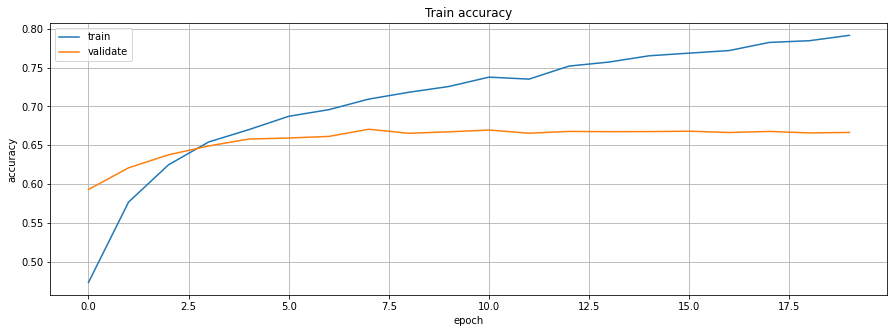

In [ ]:
#Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()
plt.show()

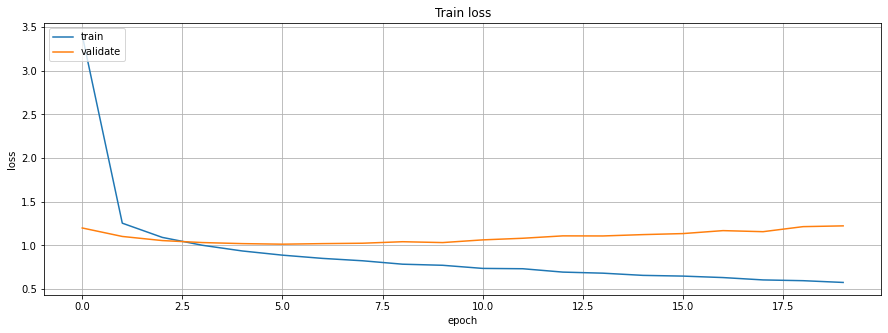

In [ ]:
#Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()
plt.show()

## Evaluate the model on test set

In [ ]:
results = model.evaluate(x_test_vgg, y_test ,batch_size = 128)
print(f"{model.metrics_names} = {results}")

79/79 [==============================] - 1s 9ms/step - loss: 1.2043 - acc: 0.6690
['loss', 'acc'] = [1.204276442527771, 0.6690000295639038]


## Inference

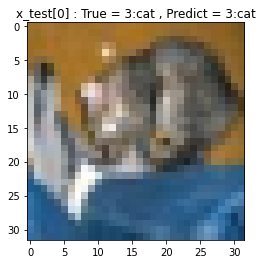

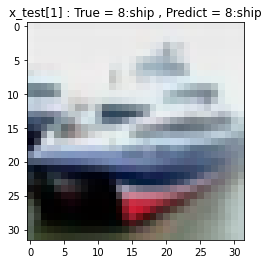

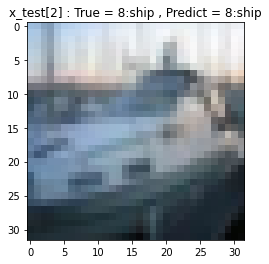

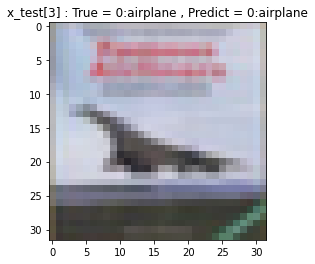

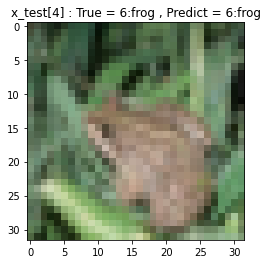

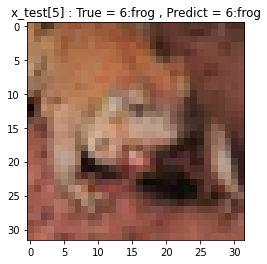

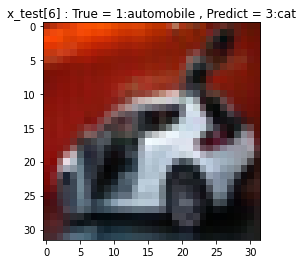

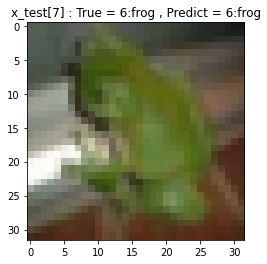

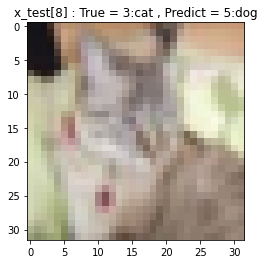

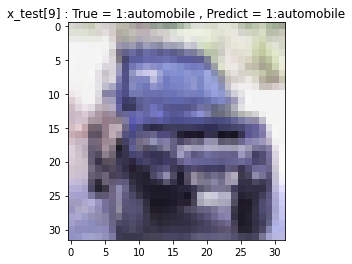

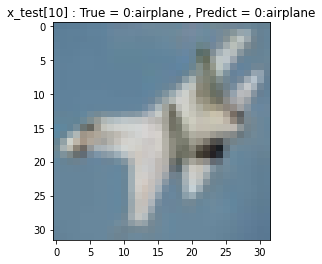

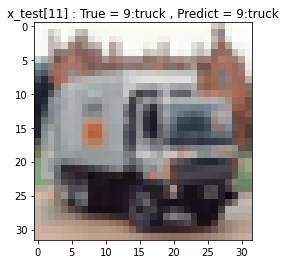

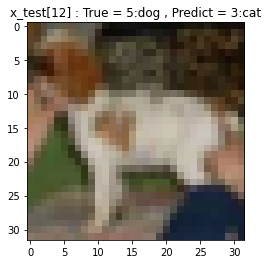

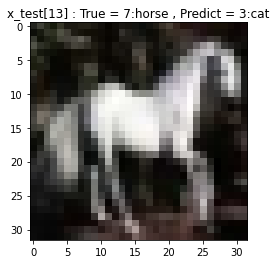

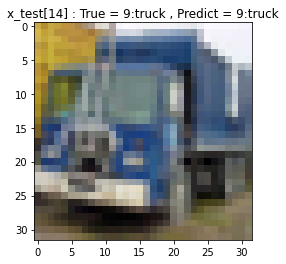

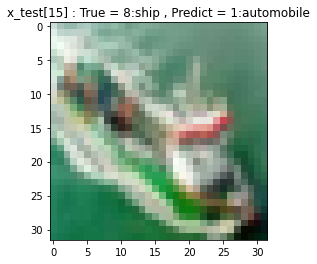

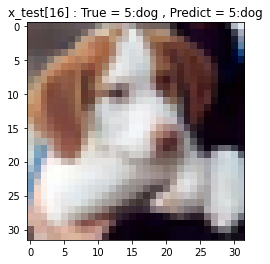

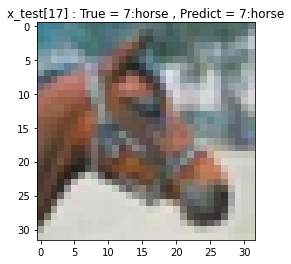

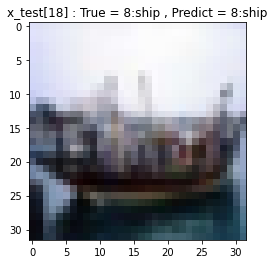

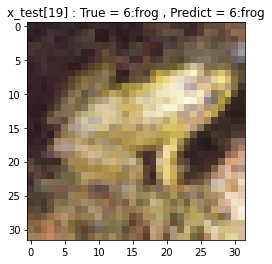

In [ ]:
#test ussing the model on the first 10 image in x_test
for i in range(20):
  y_pred = model.predict(x_test_vgg[i].reshape(1,32,32,3))

  plt.imshow( x_test[i])
  plt.title(f"x_test[{i}] : True = {y_test[i][0]}:{cifar10_labels[int(y_test[i])]} , Predict = {np.argmax(y_pred)}:{cifar10_labels[np.argmax(y_pred)]}")
  plt.show()
